In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
from torchvision import models as mods
import matplotlib.pyplot as plt
import os, PIL
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from meanshift import *

MVTEC_PATH="../../../../nas-files/mvtec"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

net, layer_map = get_fmap("eff")
net = net.to(device)
net = net.eval()

MVTEC.CLASSES

['bottle',
 'carpet',
 'leather',
 'pill',
 'tile',
 'wood',
 'cable',
 'grid',
 'toothbrush',
 'zipper',
 'capsule',
 'hazelnut',
 'metal_nut',
 'screw',
 'transistor']

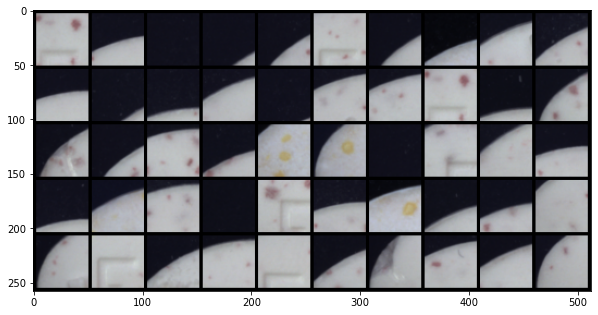

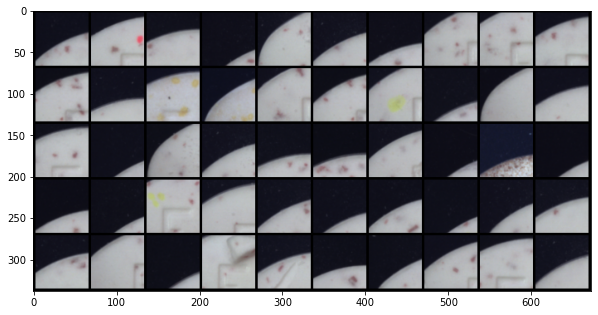

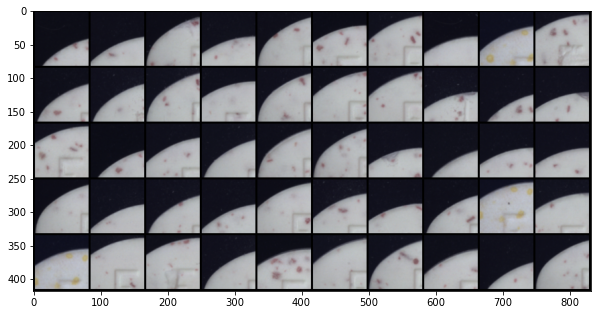

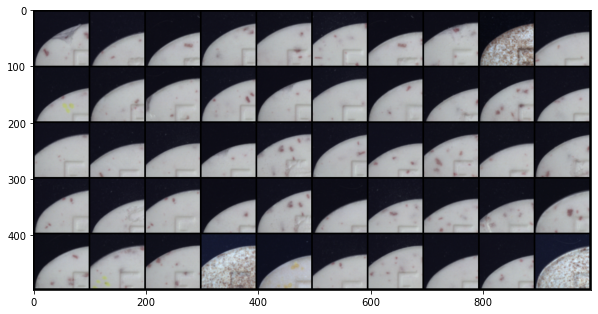

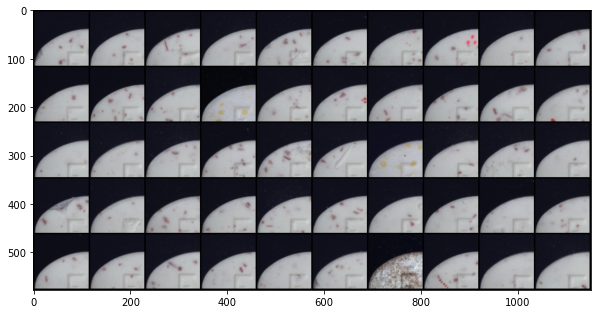

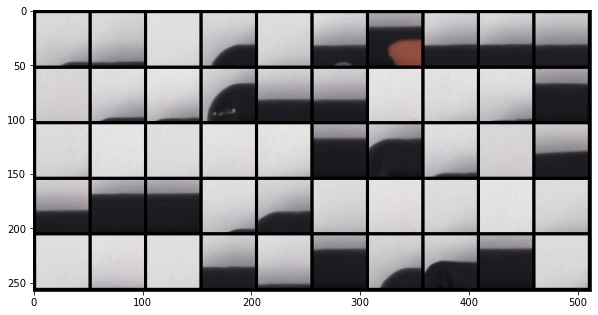

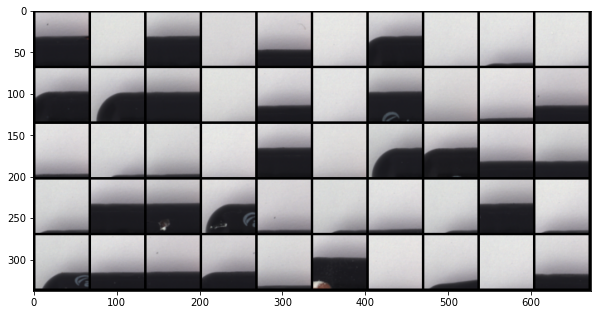

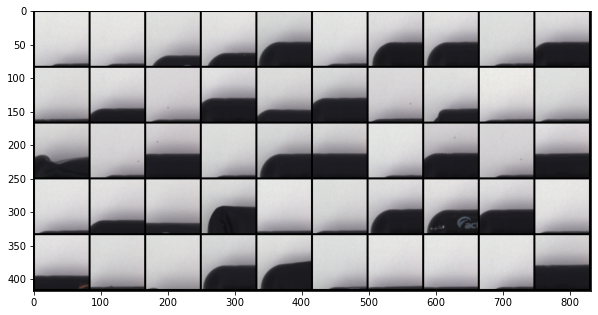

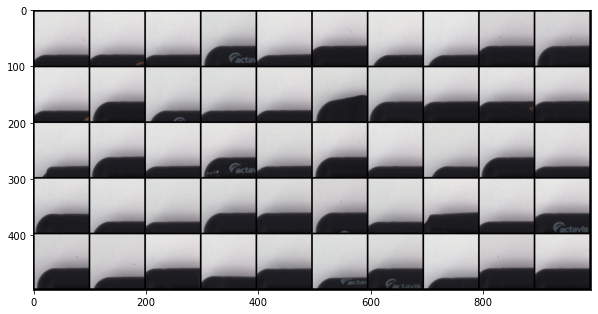

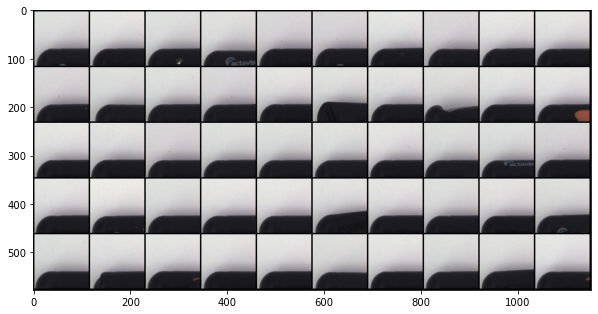

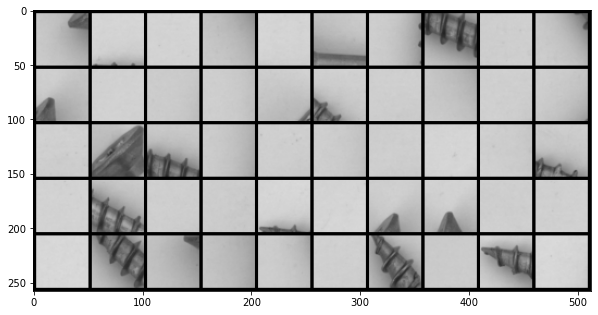

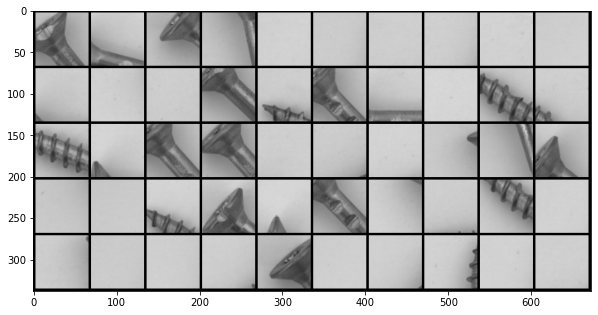

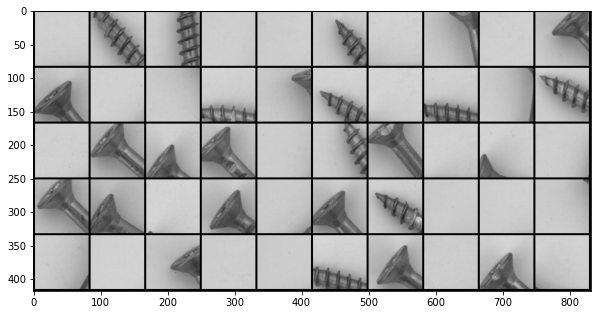

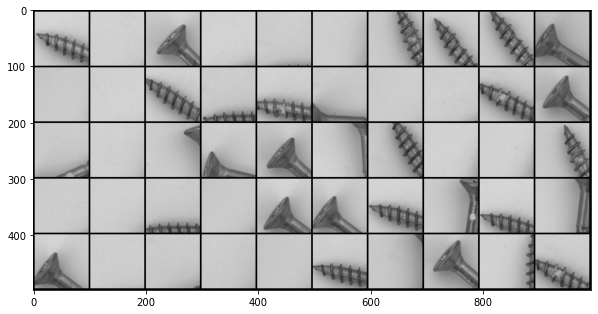

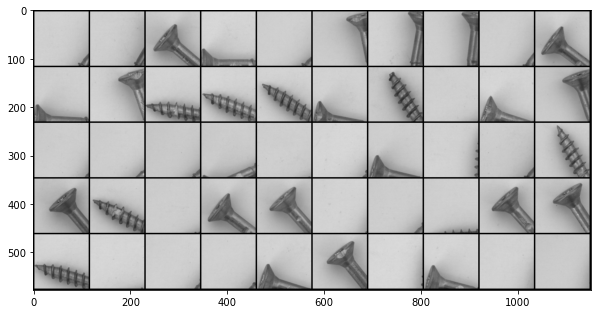

In [241]:
plt.rcParams["figure.figsize"] = (10, 10)

for clazz in [3, 10, 13]:
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=1, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=-1)
    for P in [48, 64, 80, 96, 112]:
        patches = i2col(X_test_[:, :, :112, :112], (3, 112, 112), BSZ=(P, P), padding=0, stride=16)
        patches = patches.reshape(-1, 3, P, P)
        np.random.shuffle(patches)
        plt.imshow(torchvision.utils.make_grid(torch.from_numpy(patches)[:50], nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ).numpy().transpose(1,2,0))
        plt.show()

In [166]:
np.random.seed(42)

log = []
blocks = [5,6]
P = 64
s = 16
p = 1
n = 100000

for P in [48, 64, 80, 96, 112, 128]:
   
    for run in range(3):
        
        for clazz in [3, 10, 13]:

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            for A in [48]: # 64, 80, 96, 112, 128, 144]:

                if A < P:
                    continue

                r = int( (A - P)/s + 1 )

                mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)
                s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)
                s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)

                auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                intra_var = intra_class_variance(X, T, mu, means, cov, BSZ=(p, p), rho=r)
                inter_var = inter_class_variance(means)
                dif_var   = intra_var - inter_var

                log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], len(X_), len(X)*X.shape[2]*X.shape[3], cov.shape[0], r, intra_var, inter_var, dif_var, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "n_patches", "dim", "rho", "intra_var", "inter_var", "dif_var", "auc", "auc_local"])) 

                display(log[-1])
    

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  48  48  16   1      5       267     38448  2448   1   

    intra_var inter_var     dif_var                 auc          auc_local  
0  107229.586  240889.4  -133659.81  0.8592471358428805  0.906164757228587

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0    10    capsule  48  48  16   1      5       219     31536  2448   1   

   intra_var  inter_var     dif_var                 auc          auc_local  
0  41024.594  272084.56  -231059.97  0.9485440765855605  0.957718388512166

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0    13      screw  48  48  16   1      5       320     46080  2448   1   

   intra_var inter_var    dif_var                auc           auc_local  
0  273590.56   37595.9  235994.66  0.754457880713261  0.7909407665505227

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   1     3       pill  48  48  16   1      5       267     38448  2448   1   

   intra_var  inter_var     dif_var                 auc           auc_local  
0  107288.37  241294.44  -134006.06  0.8734315330060012  0.9263502454991817

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   1    10    capsule  48  48  16   1      5       219     31536  2448   1   

  intra_var inter_var     dif_var                 auc           auc_local  
0  40525.83  271780.0  -231254.17  0.9090546469884324  0.9573195053849223

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   1    13      screw  48  48  16   1      5       320     46080  2448   1   

   intra_var  inter_var   dif_var                 auc           auc_local  
0  273808.56  37760.477  236048.1  0.7882762861242057  0.8141012502562001

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   2     3       pill  48  48  16   1      5       267     38448  2448   1   

   intra_var inter_var     dif_var                 auc           auc_local  
0  107489.09  240806.7  -133317.61  0.8824331696672121  0.9282596835788325

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   2    10    capsule  48  48  16   1      5       219     31536  2448   1   

  intra_var  inter_var     dif_var                 auc           auc_local  
0  40501.14  272053.03  -231551.89  0.8895093737534903  0.9309932189868368

run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   2    13      screw  48  48  16   1      5       320     46080  2448   1   

   intra_var inter_var   dif_var                 auc           auc_local  
0  274869.06  37764.97  237104.1  0.6956343513014962  0.8311129329780693

KeyboardInterrupt: 

In [2]:
log = torch.load("experiments/pill_capsule_skrew_log_3.pth.tar") 

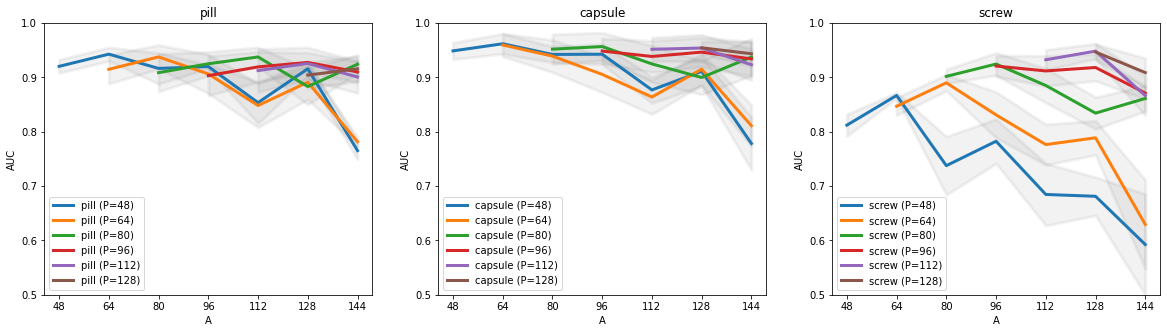

In [3]:
import tikzplotlib
plt.rcParams["figure.figsize"] = (20, 5)

Ps = [48, 64, 80, 96, 112, 128]
As = [48, 64, 80, 96, 112, 128, 144]

for i,clazz in enumerate([3, 10, 13]):
    plt.subplot(1,3,i+1)
    for P in Ps:
        #log_ = pd.concat(log)
        log_ = log
        log_ = log_[log_["class"] == str(clazz)]
        log__ = log_[log_["P"] == str(P)]
        dat = []
        for A in As:
            log___ = log__[log__["A"] == str(A)]
            if len(log___) > 0:
                y = log___[["auc_local","run"]].astype(np.float32).mean()["auc_local"]
                ci = log___[["auc_local","run"]].astype(np.float32).std()["auc_local"]
                dat.append((A, y, ci))
        dat = np.asarray(dat)
        x = dat.T[0]
        y = dat.T[1]
        ci = dat.T[2]
        plt.plot(x, y, label=f"{MVTEC.CLASSES[clazz]} (P={P})", linewidth=3.0)
        plt.fill_between(x, y+ci, y-ci, color='grey', alpha=.1, linewidth=3.0)
        plt.xticks(As)

    plt.title(f"{MVTEC.CLASSES[clazz]}")
    plt.xlabel("A")
    plt.ylabel("AUC")
    plt.ylim(0.5, 1.0)
    plt.legend()
#tikzplotlib.save("pill_capsule_screw_P_vs_A.tex")

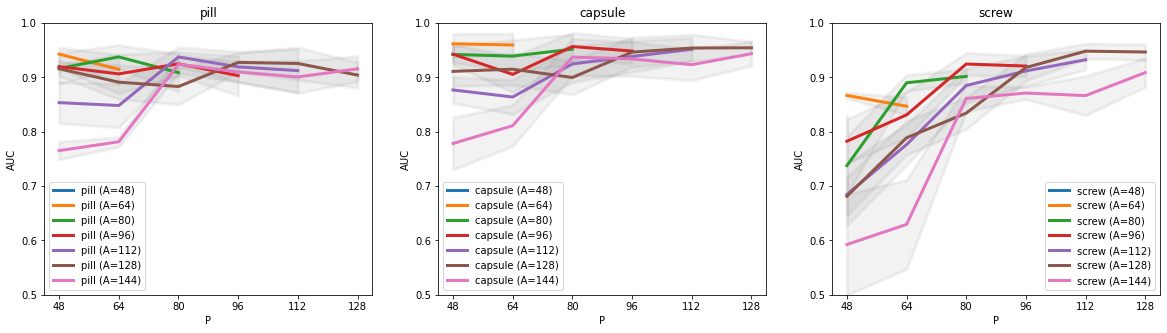

In [31]:
for i,clazz in enumerate([3, 10, 13]):
    plt.subplot(1,3,i+1)
    for A in As:
        #log_ = pd.concat(log)
        log_ = log
        log_ = log_[log_["class"] == str(clazz)]
        log__ = log_[log_["A"] == str(A)]
        dat = []
        for P in Ps:
            log___ = log__[log__["P"] == str(P)]
            if len(log___) > 0:
                y = log___[["auc_local","run"]].astype(np.float32).mean()["auc_local"]
                ci = log___[["auc_local","run"]].astype(np.float32).std()["auc_local"]
                dat.append((P, y, ci))
        dat = np.asarray(dat)
        x = dat.T[0]
        y = dat.T[1]
        ci = dat.T[2]
        plt.plot(x, y, label=f"{MVTEC.CLASSES[clazz]} (A={A})", linewidth=3.0)
        plt.fill_between(x, y+ci, y-ci, color='grey', alpha=.1, linewidth=3.0)
        plt.xticks(Ps)

    plt.title(f"{MVTEC.CLASSES[clazz]}")
    plt.xlabel("P")
    plt.ylabel("AUC")
    plt.ylim(0.5, 1.0)
    plt.legend()      

# Visualize Inner/Inter Class Variance

In [16]:
log = []

As = [64, 80, 96, 112, 128, 144]
P_fixed = 64
s = 16
blocks = [5,6]
p = 1
n = 100000
run = -1


for A in As:
    for run in range(1):
        for clazz in [3, 10, 13]:

            for i,P in enumerate([48, 64, 80, 96, 112]):
                
                if P > A:
                    continue

                X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

                X = patches_to_feature_space(X_, net, P, s, blocks=blocks, reshape=(P_fixed, P_fixed))
                X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks, reshape=(P_fixed, P_fixed))
                X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks, reshape=(P_fixed, P_fixed))

                #A = 224
                r = int( (A - P_fixed)/s + 1 )

                mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)
                s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)
                s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)

                auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                intra_var = intra_class_variance(X, T, mu, means, cov, BSZ=(p, p), rho=r)
                inter_var = inter_class_variance(means)
                dif_var   = intra_var - inter_var
                kurt, negent = kurtosis_negentropy(X, T, mu, means, cov,  BSZ=(p, p))

                log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], len(X_), len(X)*X.shape[2]*X.shape[3], cov.shape[0], r, intra_var, inter_var, dif_var,  kurt, negent, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "n_patches", "dim", "rho", "intra_var", "inter_var", "dif_var", "kurt", "negent", "auc", "auc_local"])) 

            display(pd.concat(log[-3:]))


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38448, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((32307, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   

  intra_var inter_var     dif_var        kurt      negent                 auc  \
0  207147.5  435619.0   -228471.5    4.170957    0.087508  0.8573376977632295   
0  201542.5  414894.2  -213351.69  0.44575965  0.08403374   0.872885979268958   

            auc_local  
0  0.8840698308783416  
0   0.884342607746863

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((31536, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((26499, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   
0   0    10    capsule  64  48  16   1      5       219     31536  4352   1   
0   0    10    capsule  64  64  16   1      5       219     26499  4352   1   

   intra_var  inter_var     dif_var        kurt       negent  \
0   207147.5   435619.0   -228471.5    4.170957     0.087508   
0   201542.5   414894.2  -213351.69  0.44575965   0.08403374   
0  89378.766  599297.75   -509919.0   3.6731255  0.105866656   
0   80780.16   591426.6  -510646.47  0.21523535   0.10468038   

                  auc           auc_local  
0  0.8573376977632295  0.8840698308783416  
0   0.872885979268958   0.884342607746863  
0  0.9417630634224172  0.9613083366573594  
0  0.9545273234942162  0.9541284403669725

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((46080, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38720, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   
0   0    10    capsule  64  48  16   1      5       219     31536  4352   1   
0   0    10    capsule  64  64  16   1      5       219     26499  4352   1   
0   0    13      screw  64  48  16   1      5       320     46080  4352   1   
0   0    13      screw  64  64  16   1      5       320     38720  4352   1   

   intra_var   inter_var     dif_var        kurt       negent  \
0   207147.5    435619.0   -228471.5    4.170957     0.087508   
0   201542.5    414894.2  -213351.69  0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0   3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47  0.21523535   0.10468038   
0   648986.5  110673.555   538312.94  12.4071665  0.075958684   
0   663989.8   114860.44    549129.4  0.74783254  0.089486554   

                  auc           auc_local  
0  0.8573376977632295  0.8840698308783416  
0   0.872885979268958   0.884342607746863  
0  0.9417630634224172  0.9613083366573594  
0  0.9545273234942162  0.9541284403669725  
0  0.7661406025824964  0.8481246156999386  
0  0.8104119696659151  0.8284484525517524

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38448, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((32307, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((26700, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   
0   0    10    capsule  64  48  16   1      5       219     31536  4352   1   
0   0    10    capsule  64  64  16   1      5       219     26499  4352   1   
0   0    13      screw  64  48  16   1      5       320     46080  4352   1   
0   0    13      screw  64  64  16   1      5       320     38720  4352   1   
0   0     3       pill  80  48  16   1      5       267     38448  4352   2   
0   0     3       pill  80  64  16   1      5       267     32307  4352   2   
0   0     3       pill  80  80  16   1      5       267     26700  4352   2   

   intra_var   inter_var     dif_var        kurt       negent  \
0   207147.5    435619.0   -228471.5    4.170957     0.087508   
0   201542.5    414894.2  -213351.69  0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0   3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47  0.21523535   0.10468038   
0   648986.5  110673.555   538312.94  12.4071665  0.075958684   
0   663989.8   114860.44    549129.4  0.74783254  0.089486554   
0  460192.28   211801.19    248391.1    4.185259  0.086661495   
0  475057.25   219154.69   255902.56   0.4478493   0.07832342   
0   386713.2    274807.7    111905.5   1.1332752  0.088239744   

                  auc           auc_local  
0  0.8573376977632295  0.8840698308783416  
0   0.872885979268958   0.884342607746863  
0  0.9417630634224172  0.9613083366573594  
0  0.9545273234942162  0.9541284403669725  
0  0.7661406025824964  0.8481246156999386  
0  0.8104119696659151  0.8284484525517524  
0  0.8573376977632295  0.9097108565193671  
0   0.872885979268958  0.9124386252045827  
0  0.8737043098745227  0.9083469721767594

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((31536, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((26499, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((21900, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   
0   0    10    capsule  64  48  16   1      5       219     31536  4352   1   
0   0    10    capsule  64  64  16   1      5       219     26499  4352   1   
0   0    13      screw  64  48  16   1      5       320     46080  4352   1   
0   0    13      screw  64  64  16   1      5       320     38720  4352   1   
0   0     3       pill  80  48  16   1      5       267     38448  4352   2   
0   0     3       pill  80  64  16   1      5       267     32307  4352   2   
0   0     3       pill  80  80  16   1      5       267     26700  4352   2   
0   0    10    capsule  80  48  16   1      5       219     31536  4352   2   
0   0    10    capsule  80  64  16   1      5       219     26499  4352   2   
0   0    10    capsule  80  80  16   1      5       219     21900  4352   2   

   intra_var   inter_var     dif_var        kurt       negent  \
0   207147.5    435619.0   -228471.5    4.170957     0.087508   
0   201542.5    414894.2  -213351.69  0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0   3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47  0.21523535   0.10468038   
0   648986.5  110673.555   538312.94  12.4071665  0.075958684   
0   663989.8   114860.44    549129.4  0.74783254  0.089486554   
0  460192.28   211801.19    248391.1    4.185259  0.086661495   
0  475057.25   219154.69   255902.56   0.4478493   0.07832342   
0   386713.2    274807.7    111905.5   1.1332752  0.088239744   
0  323570.47   388493.66  -64923.188   3.7050931   0.10845824   
0   445374.2   303066.03   142308.16   0.2182953   0.10706551   
0  310077.12    331147.8  -21070.688   1.4656479   0.10349496   

                  auc           auc_local  
0  0.8573376977632295  0.8840698308783416  
0   0.872885979268958   0.884342607746863  
0  0.9417630634224172  0.9613083366573594  
0  0.9545273234942162  0.9541284403669725  
0  0.7661406025824964  0.8481246156999386  
0  0.8104119696659151  0.8284484525517524  
0  0.8573376977632295  0.9097108565193671  
0   0.872885979268958  0.9124386252045827  
0  0.8737043098745227  0.9083469721767594  
0  0.9417630634224172  0.9692859992022338  
0  0.9545273234942162  0.9425608296769047  
0  0.9433585959313922  0.9345831671320304

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((46080, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38720, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((32000, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   
0   0    10    capsule  64  48  16   1      5       219     31536  4352   1   
0   0    10    capsule  64  64  16   1      5       219     26499  4352   1   
0   0    13      screw  64  48  16   1      5       320     46080  4352   1   
0   0    13      screw  64  64  16   1      5       320     38720  4352   1   
0   0     3       pill  80  48  16   1      5       267     38448  4352   2   
0   0     3       pill  80  64  16   1      5       267     32307  4352   2   
0   0     3       pill  80  80  16   1      5       267     26700  4352   2   
0   0    10    capsule  80  48  16   1      5       219     31536  4352   2   
0   0    10    capsule  80  64  16   1      5       219     26499  4352   2   
0   0    10    capsule  80  80  16   1      5       219     21900  4352   2   
0   0    13      screw  80  48  16   1      5       320     46080  4352   2   
0   0    13      screw  80  64  16   1      5       320     38720  4352   2   
0   0    13      screw  80  80  16   1      5       320     32000  4352   2   

   intra_var   inter_var     dif_var        kurt       negent  \
0   207147.5    435619.0   -228471.5    4.170957     0.087508   
0   201542.5    414894.2  -213351.69  0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0   3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47  0.21523535   0.10468038   
0   648986.5  110673.555   538312.94  12.4071665  0.075958684   
0   663989.8   114860.44    549129.4  0.74783254  0.089486554   
0  460192.28   211801.19    248391.1    4.185259  0.086661495   
0  475057.25   219154.69   255902.56   0.4478493   0.07832342   
0   386713.2    274807.7    111905.5   1.1332752  0.088239744   
0  323570.47   388493.66  -64923.188   3.7050931   0.10845824   
0   445374.2   303066.03   142308.16   0.2182953   0.10706551   
0  310077.12    331147.8  -21070.688   1.4656479   0.10349496   
0  661697.25    97328.99   564368.25   12.431623   0.08075383   
0  700691.75   93488.945    607202.8   0.7460802   0.09082527   
0   667604.5   95525.336    572079.2    2.541194  0.096599005   

                  auc           auc_local  
0  0.8573376977632295  0.8840698308783416  
0   0.872885979268958   0.884342607746863  
0  0.9417630634224172  0.9613083366573594  
0  0.9545273234942162  0.9541284403669725  
0  0.7661406025824964  0.8481246156999386  
0  0.8104119696659151  0.8284484525517524  
0  0.8573376977632295  0.9097108565193671  
0   0.872885979268958  0.9124386252045827  
0  0.8737043098745227  0.9083469721767594  
0  0.9417630634224172  0.9692859992022338  
0  0.9545273234942162  0.9425608296769047  
0  0.9433585959313922  0.9345831671320304  
0  0.7659356425497028  0.8825579012092641  
0  0.8104119696659151  0.8942406230784996  
0  0.8673908587825374  0.9229350276696046

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38448, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((32307, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((26700, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((21627, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   
0   0    10    capsule  64  48  16   1      5       219     31536  4352   1   
0   0    10    capsule  64  64  16   1      5       219     26499  4352   1   
0   0    13      screw  64  48  16   1      5       320     46080  4352   1   
0   0    13      screw  64  64  16   1      5       320     38720  4352   1   
0   0     3       pill  80  48  16   1      5       267     38448  4352   2   
0   0     3       pill  80  64  16   1      5       267     32307  4352   2   
0   0     3       pill  80  80  16   1      5       267     26700  4352   2   
0   0    10    capsule  80  48  16   1      5       219     31536  4352   2   
0   0    10    capsule  80  64  16   1      5       219     26499  4352   2   
0   0    10    capsule  80  80  16   1      5       219     21900  4352   2   
0   0    13      screw  80  48  16   1      5       320     46080  4352   2   
0   0    13      screw  80  64  16   1      5       320     38720  4352   2   
0   0    13      screw  80  80  16   1      5       320     32000  4352   2   
0   0     3       pill  96  48  16   1      5       267     38448  4352   3   
0   0     3       pill  96  64  16   1      5       267     32307  4352   3   
0   0     3       pill  96  80  16   1      5       267     26700  4352   3   
0   0     3       pill  96  96  16   1      5       267     21627  4352   3   

   intra_var   inter_var     dif_var          kurt       negent  \
0   207147.5    435619.0   -228471.5      4.170957     0.087508   
0   201542.5    414894.2  -213351.69    0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0     3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47    0.21523535   0.10468038   
0   648986.5  110673.555   538312.94    12.4071665  0.075958684   
0   663989.8   114860.44    549129.4    0.74783254  0.089486554   
0  460192.28   211801.19    248391.1      4.185259  0.086661495   
0  475057.25   219154.69   255902.56     0.4478493   0.07832342   
0   386713.2    274807.7    111905.5     1.1332752  0.088239744   
0  323570.47   388493.66  -64923.188     3.7050931   0.10845824   
0   445374.2   303066.03   142308.16     0.2182953   0.10706551   
0  310077.12    331147.8  -21070.688     1.4656479   0.10349496   
0  661697.25    97328.99   564368.25     12.431623   0.08075383   
0  700691.75   93488.945    607202.8     0.7460802   0.09082527   
0   667604.5   95525.336    572079.2      2.541194  0.096599005   
0   538679.7   123162.76   415516.94     4.1804414   0.08684083   
0   565954.9   128185.66   437769.22    0.44815293  0.088818245   
0  517491.06   164099.92   353391.12     1.1351945   0.08483957   
0  474376.78   209340.08    265036.7  -0.013806624   0.08316015   

                  auc           auc_local  
0  0.8573376977632295  0.8840698308783416  
0   0.872885979268958   0.884342607746863  
0  0.9417630634224172  0.9613083366573594  
0  0.9545273234942162  0.9541284403669725  
0  0.7661406025824964  0.8481246156999386  
0  0.8104119696659151  0.8284484525517524  
0  0.8573376977632295  0.9097108565193671  
0   0.872885979268958  0.9124386252045827  
0  0.8737043098745227  0.9083469721767594  
0  0.9417630634224172  0.9692859992022338  
0  0.9545273234942162  0.9425608296769047  
0  0.9433585959313922  0.9345831671320304  
0  0.7659356425497028  0.8825579012092641  
0  0.8104119696659151  0.8942406230784996  
0  0.8673908587825374  0.9229350276696046  
0  0.8573376977632295   0.875886524822695  
0   0.872885979268958  0.8660665575559192  
0  0.8737043098745227  0.9064375340971086  
0  0.8764320785597381  0.8998908892525914

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((31536, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((26499, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((21900, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((17739, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   
0   0    10    capsule  64  48  16   1      5       219     31536  4352   1   
0   0    10    capsule  64  64  16   1      5       219     26499  4352   1   
0   0    13      screw  64  48  16   1      5       320     46080  4352   1   
0   0    13      screw  64  64  16   1      5       320     38720  4352   1   
0   0     3       pill  80  48  16   1      5       267     38448  4352   2   
0   0     3       pill  80  64  16   1      5       267     32307  4352   2   
0   0     3       pill  80  80  16   1      5       267     26700  4352   2   
0   0    10    capsule  80  48  16   1      5       219     31536  4352   2   
0   0    10    capsule  80  64  16   1      5       219     26499  4352   2   
0   0    10    capsule  80  80  16   1      5       219     21900  4352   2   
0   0    13      screw  80  48  16   1      5       320     46080  4352   2   
0   0    13      screw  80  64  16   1      5       320     38720  4352   2   
0   0    13      screw  80  80  16   1      5       320     32000  4352   2   
0   0     3       pill  96  48  16   1      5       267     38448  4352   3   
0   0     3       pill  96  64  16   1      5       267     32307  4352   3   
0   0     3       pill  96  80  16   1      5       267     26700  4352   3   
0   0     3       pill  96  96  16   1      5       267     21627  4352   3   
0   0    10    capsule  96  48  16   1      5       219     31536  4352   3   
0   0    10    capsule  96  64  16   1      5       219     26499  4352   3   
0   0    10    capsule  96  80  16   1      5       219     21900  4352   3   
0   0    10    capsule  96  96  16   1      5       219     17739  4352   3   

   intra_var   inter_var     dif_var          kurt       negent  \
0   207147.5    435619.0   -228471.5      4.170957     0.087508   
0   201542.5    414894.2  -213351.69    0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0     3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47    0.21523535   0.10468038   
0   648986.5  110673.555   538312.94    12.4071665  0.075958684   
0   663989.8   114860.44    549129.4    0.74783254  0.089486554   
0  460192.28   211801.19    248391.1      4.185259  0.086661495   
0  475057.25   219154.69   255902.56     0.4478493   0.07832342   
0   386713.2    274807.7    111905.5     1.1332752  0.088239744   
0  323570.47   388493.66  -64923.188     3.7050931   0.10845824   
0   445374.2   303066.03   142308.16     0.2182953   0.10706551   
0  310077.12    331147.8  -21070.688     1.4656479   0.10349496   
0  661697.25    97328.99   564368.25     12.431623   0.08075383   
0  700691.75   93488.945    607202.8     0.7460802   0.09082527   
0   667604.5   95525.336    572079.2      2.541194  0.096599005   
0   538679.7   123162.76   415516.94     4.1804414   0.08684083   
0   565954.9   128185.66   437769.22    0.44815293  0.088818245   
0  517491.06   164099.92   353391.12     1.1351945   0.08483957   
0  474376.78   209340.08    265036.7  -0.013806624   0.08316015   
0  442492.06    288541.9   153950.16       3.69392   0.11049458   
0  636132.25    174899.4   461232.84     0.2126498    0.1065288   
0  490982.56   185111.98   305870.56     1.4673806   0.10860923   
0  395308.44   210117.34    185191.1    0.56978595  0.118983686   

                  auc           auc_local  
0  0.8573376977632295  0.8840698308783416  
0   0.872885979268958   0.884342607746863  
0  0.9417630634224172  0.9613083366573594  
0  0.9545273234942162  0.9541284403669725  
0  0.7661406025824964  0.8481246156999386  
0  0.8104119696659151  0.8284484525517524  
0  0.8573376977632295  0.9097108565193671  
0   0.872885979268958  0.9124386252045827  
0  0.8737043098745227  0.9083469721767594  
0  0.9417630634224172  0.9692859992022338  
0  0.9545273

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((46080, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38720, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((32000, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((25920, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  64  48  16   1      5       267     38448  4352   1   
0   0     3       pill  64  64  16   1      5       267     32307  4352   1   
0   0    10    capsule  64  48  16   1      5       219     31536  4352   1   
0   0    10    capsule  64  64  16   1      5       219     26499  4352   1   
0   0    13      screw  64  48  16   1      5       320     46080  4352   1   
0   0    13      screw  64  64  16   1      5       320     38720  4352   1   
0   0     3       pill  80  48  16   1      5       267     38448  4352   2   
0   0     3       pill  80  64  16   1      5       267     32307  4352   2   
0   0     3       pill  80  80  16   1      5       267     26700  4352   2   
0   0    10    capsule  80  48  16   1      5       219     31536  4352   2   
0   0    10    capsule  80  64  16   1      5       219     26499  4352   2   
0   0    10    capsule  80  80  16   1      5       219     21900  4352   2   
0   0    13      screw  80  48  16   1      5       320     46080  4352   2   
0   0    13      screw  80  64  16   1      5       320     38720  4352   2   
0   0    13      screw  80  80  16   1      5       320     32000  4352   2   
0   0     3       pill  96  48  16   1      5       267     38448  4352   3   
0   0     3       pill  96  64  16   1      5       267     32307  4352   3   
0   0     3       pill  96  80  16   1      5       267     26700  4352   3   
0   0     3       pill  96  96  16   1      5       267     21627  4352   3   
0   0    10    capsule  96  48  16   1      5       219     31536  4352   3   
0   0    10    capsule  96  64  16   1      5       219     26499  4352   3   
0   0    10    capsule  96  80  16   1      5       219     21900  4352   3   
0   0    10    capsule  96  96  16   1      5       219     17739  4352   3   
0   0    13      screw  96  48  16   1      5       320     46080  4352   3   
0   0    13      screw  96  64  16   1      5       320     38720  4352   3   
0   0    13      screw  96  80  16   1      5       320     32000  4352   3   
0   0    13      screw  96  96  16   1      5       320     25920  4352   3   

   intra_var   inter_var     dif_var          kurt       negent  \
0   207147.5    435619.0   -228471.5      4.170957     0.087508   
0   201542.5    414894.2  -213351.69    0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0     3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47    0.21523535   0.10468038   
0   648986.5  110673.555   538312.94    12.4071665  0.075958684   
0   663989.8   114860.44    549129.4    0.74783254  0.089486554   
0  460192.28   211801.19    248391.1      4.185259  0.086661495   
0  475057.25   219154.69   255902.56     0.4478493   0.07832342   
0   386713.2    274807.7    111905.5     1.1332752  0.088239744   
0  323570.47   388493.66  -64923.188     3.7050931   0.10845824   
0   445374.2   303066.03   142308.16     0.2182953   0.10706551   
0  310077.12    331147.8  -21070.688     1.4656479   0.10349496   
0  661697.25    97328.99   564368.25     12.431623   0.08075383   
0  700691.75   93488.945    607202.8     0.7460802   0.09082527   
0   667604.5   95525.336    572079.2      2.541194  0.096599005   
0   538679.7   123162.76   415516.94     4.1804414   0.08684083   
0   565954.9   128185.66   437769.22    0.44815293  0.088818245   
0  517491.06   164099.92   353391.12     1.1351945   0.08483957   
0  474376.78   209340.08    265036.7  -0.013806624   0.08316015   
0  442492.06    288541.9   153950.16       3.69392   0.11049458   
0  636132.25    174899.4   461232.84     0.2126498    0.1065288   
0  490982.56   185111.98   305870.56     1.4673806   0.10860923   
0  395308.44   210117.34    185191.1    0.56978595  0.118983686   
0  681909.44     80760.7   601148.75     12.409894   0.08426504   
0   755118.2    75587.92   679530.25    0.75100166   0.09321002   
0  714443.25   64558.715   649884.56      2.533

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38448, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((32307, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((26700, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((21627, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((17088, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill   64   48  16   1      5       267     38448  4352   1   
0   0     3       pill   64   64  16   1      5       267     32307  4352   1   
0   0    10    capsule   64   48  16   1      5       219     31536  4352   1   
0   0    10    capsule   64   64  16   1      5       219     26499  4352   1   
0   0    13      screw   64   48  16   1      5       320     46080  4352   1   
0   0    13      screw   64   64  16   1      5       320     38720  4352   1   
0   0     3       pill   80   48  16   1      5       267     38448  4352   2   
0   0     3       pill   80   64  16   1      5       267     32307  4352   2   
0   0     3       pill   80   80  16   1      5       267     26700  4352   2   
0   0    10    capsule   80   48  16   1      5       219     31536  4352   2   
0   0    10    capsule   80   64  16   1      5       219     26499  4352   2   
0   0    10    capsule   80   80  16   1      5       219     21900  4352   2   
0   0    13      screw   80   48  16   1      5       320     46080  4352   2   
0   0    13      screw   80   64  16   1      5       320     38720  4352   2   
0   0    13      screw   80   80  16   1      5       320     32000  4352   2   
0   0     3       pill   96   48  16   1      5       267     38448  4352   3   
0   0     3       pill   96   64  16   1      5       267     32307  4352   3   
0   0     3       pill   96   80  16   1      5       267     26700  4352   3   
0   0     3       pill   96   96  16   1      5       267     21627  4352   3   
0   0    10    capsule   96   48  16   1      5       219     31536  4352   3   
0   0    10    capsule   96   64  16   1      5       219     26499  4352   3   
0   0    10    capsule   96   80  16   1      5       219     21900  4352   3   
0   0    10    capsule   96   96  16   1      5       219     17739  4352   3   
0   0    13      screw   96   48  16   1      5       320     46080  4352   3   
0   0    13      screw   96   64  16   1      5       320     38720  4352   3   
0   0    13      screw   96   80  16   1      5       320     32000  4352   3   
0   0    13      screw   96   96  16   1      5       320     25920  4352   3   
0   0     3       pill  112   48  16   1      5       267     38448  4352   4   
0   0     3       pill  112   64  16   1      5       267     32307  4352   4   
0   0     3       pill  112   80  16   1      5       267     26700  4352   4   
0   0     3       pill  112   96  16   1      5       267     21627  4352   4   
0   0     3       pill  112  112  16   1      5       267     17088  4352   4   

   intra_var   inter_var     dif_var          kurt       negent  \
0   207147.5    435619.0   -228471.5      4.170957     0.087508   
0   201542.5    414894.2  -213351.69    0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0     3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47    0.21523535   0.10468038   
0   648986.5  110673.555   538312.94    12.4071665  0.075958684   
0   663989.8   114860.44    549129.4    0.74783254  0.089486554   
0  460192.28   211801.19    248391.1      4.185259  0.086661495   
0  475057.25   219154.69   255902.56     0.4478493   0.07832342   
0   386713.2    274807.7    111905.5     1.1332752  0.088239744   
0  323570.47   388493.66  -64923.188     3.7050931   0.10845824   
0   445374.2   303066.03   142308.16     0.2182953   0.10706551   
0  310077.12    331147.8  -21070.688     1.4656479   0.10349496   
0  661697.25    97328.99   564368.25     12.431623   0.08075383   
0  700691.75   93488.945    607202.8     0.7460802   0.09082527   
0   667604.5   95525.336    572079.2      2.541194  0.096599005   
0   538679.7   123162.76   415516.94     4.1804414   0.08684083   
0   565954.9   128185.66   437769.22    0.44815293  0.088818245   
0  517491.06   164099.92   353391.12     1.1351945   0.08483957   
0  474376.78   209340.08    265036.7  -0.013806624   0.

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((31536, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((26499, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((21900, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((17739, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((14016, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill   64   48  16   1      5       267     38448  4352   1   
0   0     3       pill   64   64  16   1      5       267     32307  4352   1   
0   0    10    capsule   64   48  16   1      5       219     31536  4352   1   
0   0    10    capsule   64   64  16   1      5       219     26499  4352   1   
0   0    13      screw   64   48  16   1      5       320     46080  4352   1   
0   0    13      screw   64   64  16   1      5       320     38720  4352   1   
0   0     3       pill   80   48  16   1      5       267     38448  4352   2   
0   0     3       pill   80   64  16   1      5       267     32307  4352   2   
0   0     3       pill   80   80  16   1      5       267     26700  4352   2   
0   0    10    capsule   80   48  16   1      5       219     31536  4352   2   
0   0    10    capsule   80   64  16   1      5       219     26499  4352   2   
0   0    10    capsule   80   80  16   1      5       219     21900  4352   2   
0   0    13      screw   80   48  16   1      5       320     46080  4352   2   
0   0    13      screw   80   64  16   1      5       320     38720  4352   2   
0   0    13      screw   80   80  16   1      5       320     32000  4352   2   
0   0     3       pill   96   48  16   1      5       267     38448  4352   3   
0   0     3       pill   96   64  16   1      5       267     32307  4352   3   
0   0     3       pill   96   80  16   1      5       267     26700  4352   3   
0   0     3       pill   96   96  16   1      5       267     21627  4352   3   
0   0    10    capsule   96   48  16   1      5       219     31536  4352   3   
0   0    10    capsule   96   64  16   1      5       219     26499  4352   3   
0   0    10    capsule   96   80  16   1      5       219     21900  4352   3   
0   0    10    capsule   96   96  16   1      5       219     17739  4352   3   
0   0    13      screw   96   48  16   1      5       320     46080  4352   3   
0   0    13      screw   96   64  16   1      5       320     38720  4352   3   
0   0    13      screw   96   80  16   1      5       320     32000  4352   3   
0   0    13      screw   96   96  16   1      5       320     25920  4352   3   
0   0     3       pill  112   48  16   1      5       267     38448  4352   4   
0   0     3       pill  112   64  16   1      5       267     32307  4352   4   
0   0     3       pill  112   80  16   1      5       267     26700  4352   4   
0   0     3       pill  112   96  16   1      5       267     21627  4352   4   
0   0     3       pill  112  112  16   1      5       267     17088  4352   4   
0   0    10    capsule  112   48  16   1      5       219     31536  4352   4   
0   0    10    capsule  112   64  16   1      5       219     26499  4352   4   
0   0    10    capsule  112   80  16   1      5       219     21900  4352   4   
0   0    10    capsule  112   96  16   1      5       219     17739  4352   4   
0   0    10    capsule  112  112  16   1      5       219     14016  4352   4   

   intra_var   inter_var     dif_var          kurt       negent  \
0   207147.5    435619.0   -228471.5      4.170957     0.087508   
0   201542.5    414894.2  -213351.69    0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0     3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47    0.21523535   0.10468038   
0   648986.5  110673.555   538312.94    12.4071665  0.075958684   
0   663989.8   114860.44    549129.4    0.74783254  0.089486554   
0  460192.28   211801.19    248391.1      4.185259  0.086661495   
0  475057.25   219154.69   255902.56     0.4478493   0.07832342   
0   386713.2    274807.7    111905.5     1.1332752  0.088239744   
0  323570.47   388493.66  -64923.188     3.7050931   0.10845824   
0   445374.2   303066.03   142308.16     0.2182953   0.10706551   
0  310077.12    331147.8  -21070.688     1.4656479   0.10349496   
0  661697.25    97328.99   564368.25     12.431623  

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((46080, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38720, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((32000, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((25920, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((20480, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill   64   48  16   1      5       267     38448  4352   1   
0   0     3       pill   64   64  16   1      5       267     32307  4352   1   
0   0    10    capsule   64   48  16   1      5       219     31536  4352   1   
0   0    10    capsule   64   64  16   1      5       219     26499  4352   1   
0   0    13      screw   64   48  16   1      5       320     46080  4352   1   
0   0    13      screw   64   64  16   1      5       320     38720  4352   1   
0   0     3       pill   80   48  16   1      5       267     38448  4352   2   
0   0     3       pill   80   64  16   1      5       267     32307  4352   2   
0   0     3       pill   80   80  16   1      5       267     26700  4352   2   
0   0    10    capsule   80   48  16   1      5       219     31536  4352   2   
0   0    10    capsule   80   64  16   1      5       219     26499  4352   2   
0   0    10    capsule   80   80  16   1      5       219     21900  4352   2   
0   0    13      screw   80   48  16   1      5       320     46080  4352   2   
0   0    13      screw   80   64  16   1      5       320     38720  4352   2   
0   0    13      screw   80   80  16   1      5       320     32000  4352   2   
0   0     3       pill   96   48  16   1      5       267     38448  4352   3   
0   0     3       pill   96   64  16   1      5       267     32307  4352   3   
0   0     3       pill   96   80  16   1      5       267     26700  4352   3   
0   0     3       pill   96   96  16   1      5       267     21627  4352   3   
0   0    10    capsule   96   48  16   1      5       219     31536  4352   3   
0   0    10    capsule   96   64  16   1      5       219     26499  4352   3   
0   0    10    capsule   96   80  16   1      5       219     21900  4352   3   
0   0    10    capsule   96   96  16   1      5       219     17739  4352   3   
0   0    13      screw   96   48  16   1      5       320     46080  4352   3   
0   0    13      screw   96   64  16   1      5       320     38720  4352   3   
0   0    13      screw   96   80  16   1      5       320     32000  4352   3   
0   0    13      screw   96   96  16   1      5       320     25920  4352   3   
0   0     3       pill  112   48  16   1      5       267     38448  4352   4   
0   0     3       pill  112   64  16   1      5       267     32307  4352   4   
0   0     3       pill  112   80  16   1      5       267     26700  4352   4   
0   0     3       pill  112   96  16   1      5       267     21627  4352   4   
0   0     3       pill  112  112  16   1      5       267     17088  4352   4   
0   0    10    capsule  112   48  16   1      5       219     31536  4352   4   
0   0    10    capsule  112   64  16   1      5       219     26499  4352   4   
0   0    10    capsule  112   80  16   1      5       219     21900  4352   4   
0   0    10    capsule  112   96  16   1      5       219     17739  4352   4   
0   0    10    capsule  112  112  16   1      5       219     14016  4352   4   
0   0    13      screw  112   48  16   1      5       320     46080  4352   4   
0   0    13      screw  112   64  16   1      5       320     38720  4352   4   
0   0    13      screw  112   80  16   1      5       320     32000  4352   4   
0   0    13      screw  112   96  16   1      5       320     25920  4352   4   
0   0    13      screw  112  112  16   1      5       320     20480  4352   4   

   intra_var   inter_var     dif_var          kurt       negent  \
0   207147.5    435619.0   -228471.5      4.170957     0.087508   
0   201542.5    414894.2  -213351.69    0.44575965   0.08403374   
0  89378.766   599297.75   -509919.0     3.6731255  0.105866656   
0   80780.16    591426.6  -510646.47    0.21523535   0.10468038   
0   648986.5  110673.555   538312.94    12.4071665  0.075958684   
0   663989.8   114860.44    549129.4    0.74783254  0.089486554   
0  460192.28   211801.19    248391.1      4.18525

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38448, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((32307, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((26700, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((21627, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((17088, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill   64   48  16   1      5       267     38448  4352   1   
0   0     3       pill   64   64  16   1      5       267     32307  4352   1   
0   0    10    capsule   64   48  16   1      5       219     31536  4352   1   
0   0    10    capsule   64   64  16   1      5       219     26499  4352   1   
0   0    13      screw   64   48  16   1      5       320     46080  4352   1   
0   0    13      screw   64   64  16   1      5       320     38720  4352   1   
0   0     3       pill   80   48  16   1      5       267     38448  4352   2   
0   0     3       pill   80   64  16   1      5       267     32307  4352   2   
0   0     3       pill   80   80  16   1      5       267     26700  4352   2   
0   0    10    capsule   80   48  16   1      5       219     31536  4352   2   
0   0    10    capsule   80   64  16   1      5       219     26499  4352   2   
0   0    10    capsule   80   80  16   1      5       219     21900  4352   2   
0   0    13      screw   80   48  16   1      5       320     46080  4352   2   
0   0    13      screw   80   64  16   1      5       320     38720  4352   2   
0   0    13      screw   80   80  16   1      5       320     32000  4352   2   
0   0     3       pill   96   48  16   1      5       267     38448  4352   3   
0   0     3       pill   96   64  16   1      5       267     32307  4352   3   
0   0     3       pill   96   80  16   1      5       267     26700  4352   3   
0   0     3       pill   96   96  16   1      5       267     21627  4352   3   
0   0    10    capsule   96   48  16   1      5       219     31536  4352   3   
0   0    10    capsule   96   64  16   1      5       219     26499  4352   3   
0   0    10    capsule   96   80  16   1      5       219     21900  4352   3   
0   0    10    capsule   96   96  16   1      5       219     17739  4352   3   
0   0    13      screw   96   48  16   1      5       320     46080  4352   3   
0   0    13      screw   96   64  16   1      5       320     38720  4352   3   
0   0    13      screw   96   80  16   1      5       320     32000  4352   3   
0   0    13      screw   96   96  16   1      5       320     25920  4352   3   
0   0     3       pill  112   48  16   1      5       267     38448  4352   4   
0   0     3       pill  112   64  16   1      5       267     32307  4352   4   
0   0     3       pill  112   80  16   1      5       267     26700  4352   4   
0   0     3       pill  112   96  16   1      5       267     21627  4352   4   
0   0     3       pill  112  112  16   1      5       267     17088  4352   4   
0   0    10    capsule  112   48  16   1      5       219     31536  4352   4   
0   0    10    capsule  112   64  16   1      5       219     26499  4352   4   
0   0    10    capsule  112   80  16   1      5       219     21900  4352   4   
0   0    10    capsule  112   96  16   1      5       219     17739  4352   4   
0   0    10    capsule  112  112  16   1      5       219     14016  4352   4   
0   0    13      screw  112   48  16   1      5       320     46080  4352   4   
0   0    13      screw  112   64  16   1      5       320     38720  4352   4   
0   0    13      screw  112   80  16   1      5       320     32000  4352   4   
0   0    13      screw  112   96  16   1      5       320     25920  4352   4   
0   0    13      screw  112  112  16   1      5       320     20480  4352   4   
0   0     3       pill  128   48  16   1      5       267     38448  4352   5   
0   0     3       pill  128   64  16   1      5       267     32307  4352   5   
0   0     3       pill  128   80  16   1      5       267     26700  4352   5   
0   0     3       pill  128   96  16   1      5       267     21627  4352   5   
0   0     3       pill  128  112  16   1      5       267     17088  4352   5   

   intra_var   inter_var     dif_var          kurt       negent  \
0   207147.5    435619.0   -228471.5      4.17

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((31536, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((26499, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((21900, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((17739, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((14016, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill   64   48  16   1      5       267     38448  4352   1   
0   0     3       pill   64   64  16   1      5       267     32307  4352   1   
0   0    10    capsule   64   48  16   1      5       219     31536  4352   1   
0   0    10    capsule   64   64  16   1      5       219     26499  4352   1   
0   0    13      screw   64   48  16   1      5       320     46080  4352   1   
0   0    13      screw   64   64  16   1      5       320     38720  4352   1   
0   0     3       pill   80   48  16   1      5       267     38448  4352   2   
0   0     3       pill   80   64  16   1      5       267     32307  4352   2   
0   0     3       pill   80   80  16   1      5       267     26700  4352   2   
0   0    10    capsule   80   48  16   1      5       219     31536  4352   2   
0   0    10    capsule   80   64  16   1      5       219     26499  4352   2   
0   0    10    capsule   80   80  16   1      5       219     21900  4352   2   
0   0    13      screw   80   48  16   1      5       320     46080  4352   2   
0   0    13      screw   80   64  16   1      5       320     38720  4352   2   
0   0    13      screw   80   80  16   1      5       320     32000  4352   2   
0   0     3       pill   96   48  16   1      5       267     38448  4352   3   
0   0     3       pill   96   64  16   1      5       267     32307  4352   3   
0   0     3       pill   96   80  16   1      5       267     26700  4352   3   
0   0     3       pill   96   96  16   1      5       267     21627  4352   3   
0   0    10    capsule   96   48  16   1      5       219     31536  4352   3   
0   0    10    capsule   96   64  16   1      5       219     26499  4352   3   
0   0    10    capsule   96   80  16   1      5       219     21900  4352   3   
0   0    10    capsule   96   96  16   1      5       219     17739  4352   3   
0   0    13      screw   96   48  16   1      5       320     46080  4352   3   
0   0    13      screw   96   64  16   1      5       320     38720  4352   3   
0   0    13      screw   96   80  16   1      5       320     32000  4352   3   
0   0    13      screw   96   96  16   1      5       320     25920  4352   3   
0   0     3       pill  112   48  16   1      5       267     38448  4352   4   
0   0     3       pill  112   64  16   1      5       267     32307  4352   4   
0   0     3       pill  112   80  16   1      5       267     26700  4352   4   
0   0     3       pill  112   96  16   1      5       267     21627  4352   4   
0   0     3       pill  112  112  16   1      5       267     17088  4352   4   
0   0    10    capsule  112   48  16   1      5       219     31536  4352   4   
0   0    10    capsule  112   64  16   1      5       219     26499  4352   4   
0   0    10    capsule  112   80  16   1      5       219     21900  4352   4   
0   0    10    capsule  112   96  16   1      5       219     17739  4352   4   
0   0    10    capsule  112  112  16   1      5       219     14016  4352   4   
0   0    13      screw  112   48  16   1      5       320     46080  4352   4   
0   0    13      screw  112   64  16   1      5       320     38720  4352   4   
0   0    13      screw  112   80  16   1      5       320     32000  4352   4   
0   0    13      screw  112   96  16   1      5       320     25920  4352   4   
0   0    13      screw  112  112  16   1      5       320     20480  4352   4   
0   0     3       pill  128   48  16   1      5       267     38448  4352   5   
0   0     3       pill  128   64  16   1      5       267     32307  4352   5   
0   0     3       pill  128   80  16   1      5       267     26700  4352   5   
0   0     3       pill  128   96  16   1      5       267     21627  4352   5   
0   0     3       pill  128  112  16   1      5       267     17088  4352   5   
0   0    10    capsule  128   48  16   1      5       219     31536  4352   5   
0   0    10    capsule  128   64 

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((46080, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38720, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((32000, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((25920, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((20480, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill   64   48  16   1      5       267     38448  4352   1   
0   0     3       pill   64   64  16   1      5       267     32307  4352   1   
0   0    10    capsule   64   48  16   1      5       219     31536  4352   1   
0   0    10    capsule   64   64  16   1      5       219     26499  4352   1   
0   0    13      screw   64   48  16   1      5       320     46080  4352   1   
0   0    13      screw   64   64  16   1      5       320     38720  4352   1   
0   0     3       pill   80   48  16   1      5       267     38448  4352   2   
0   0     3       pill   80   64  16   1      5       267     32307  4352   2   
0   0     3       pill   80   80  16   1      5       267     26700  4352   2   
0   0    10    capsule   80   48  16   1      5       219     31536  4352   2   
0   0    10    capsule   80   64  16   1      5       219     26499  4352   2   
0   0    10    capsule   80   80  16   1      5       219     21900  4352   2   
0   0    13      screw   80   48  16   1      5       320     46080  4352   2   
0   0    13      screw   80   64  16   1      5       320     38720  4352   2   
0   0    13      screw   80   80  16   1      5       320     32000  4352   2   
0   0     3       pill   96   48  16   1      5       267     38448  4352   3   
0   0     3       pill   96   64  16   1      5       267     32307  4352   3   
0   0     3       pill   96   80  16   1      5       267     26700  4352   3   
0   0     3       pill   96   96  16   1      5       267     21627  4352   3   
0   0    10    capsule   96   48  16   1      5       219     31536  4352   3   
0   0    10    capsule   96   64  16   1      5       219     26499  4352   3   
0   0    10    capsule   96   80  16   1      5       219     21900  4352   3   
0   0    10    capsule   96   96  16   1      5       219     17739  4352   3   
0   0    13      screw   96   48  16   1      5       320     46080  4352   3   
0   0    13      screw   96   64  16   1      5       320     38720  4352   3   
0   0    13      screw   96   80  16   1      5       320     32000  4352   3   
0   0    13      screw   96   96  16   1      5       320     25920  4352   3   
0   0     3       pill  112   48  16   1      5       267     38448  4352   4   
0   0     3       pill  112   64  16   1      5       267     32307  4352   4   
0   0     3       pill  112   80  16   1      5       267     26700  4352   4   
0   0     3       pill  112   96  16   1      5       267     21627  4352   4   
0   0     3       pill  112  112  16   1      5       267     17088  4352   4   
0   0    10    capsule  112   48  16   1      5       219     31536  4352   4   
0   0    10    capsule  112   64  16   1      5       219     26499  4352   4   
0   0    10    capsule  112   80  16   1      5       219     21900  4352   4   
0   0    10    capsule  112   96  16   1      5       219     17739  4352   4   
0   0    10    capsule  112  112  16   1      5       219     14016  4352   4   
0   0    13      screw  112   48  16   1      5       320     46080  4352   4   
0   0    13      screw  112   64  16   1      5       320     38720  4352   4   
0   0    13      screw  112   80  16   1      5       320     32000  4352   4   
0   0    13      screw  112   96  16   1      5       320     25920  4352   4   
0   0    13      screw  112  112  16   1      5       320     20480  4352   4   
0   0     3       pill  128   48  16   1      5       267     38448  4352   5   
0   0     3       pill  128   64  16   1      5       267     32307  4352   5   
0   0     3       pill  128   80  16   1      5       267     26700  4352   5   
0   0     3       pill  128   96  16   1      5       267     21627  4352   5   
0   0     3       pill  128  112  16   1      5       267     17088  4352   5   
0   0    10    capsule  128   48  16   1      5       219     31536  4352   5   
0   0    10    capsule  128   64 

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38448, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((32307, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((26700, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((21627, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((17088, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim  \
0    0     3       pill   64   48  16   1      5       267     38448  4352   
0    0     3       pill   64   64  16   1      5       267     32307  4352   
0    0    10    capsule   64   48  16   1      5       219     31536  4352   
0    0    10    capsule   64   64  16   1      5       219     26499  4352   
0    0    13      screw   64   48  16   1      5       320     46080  4352   
..  ..   ...        ...  ...  ...  ..  ..    ...       ...       ...   ...   
0    0     3       pill  144   48  16   1      5       267     38448  4352   
0    0     3       pill  144   64  16   1      5       267     32307  4352   
0    0     3       pill  144   80  16   1      5       267     26700  4352   
0    0     3       pill  144   96  16   1      5       267     21627  4352   
0    0     3       pill  144  112  16   1      5       267     17088  4352   

   rho  intra_var   inter_var     dif_var          kurt       negent  \
0    1   207147.5    435619.0   -228471.5      4.170957     0.087508   
0    1   201542.5    414894.2  -213351.69    0.44575965   0.08403374   
0    1  89378.766   599297.75   -509919.0     3.6731255  0.105866656   
0    1   80780.16    591426.6  -510646.47    0.21523535   0.10468038   
0    1   648986.5  110673.555   538312.94    12.4071665  0.075958684   
..  ..        ...         ...         ...           ...          ...   
0    6  624907.44   28082.637    596824.8     4.1865144  0.090421654   
0    6   616435.6         0.0    616435.6    0.44883555   0.08301591   
0    6  634404.75         0.0   634404.75     1.1301086  0.086156555   
0    6  660527.06         0.0   660527.06  -0.011055844  0.082885474   
0    6  674543.25         0.0   674543.25     1.1835696   0.08054836   

                   auc           auc_local  
0   0.8573376977632295  0.8840698308783416  
0    0.872885979268958   0.884342607746863  
0   0.9417630634224172  0.9613083366573594  
0   0.9545273234942162  0.9541284403669725  
0   0.7661406025824964  0.8481246156999386  
..                 ...                 ...  
0   0.8573376977632295  0.8925259138025096  
0    0.872885979268958  0.7741407528641571  
0   0.8737043098745227  0.7853246044735407  
0   0.8764320785597381  0.8311511183851609  
0   0.8608837970540099  0.8355155482815058  

[62 rows x 19 columns]

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((31536, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((26499, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((21900, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((17739, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((14016, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim  \
0    0     3       pill   64   48  16   1      5       267     38448  4352   
0    0     3       pill   64   64  16   1      5       267     32307  4352   
0    0    10    capsule   64   48  16   1      5       219     31536  4352   
0    0    10    capsule   64   64  16   1      5       219     26499  4352   
0    0    13      screw   64   48  16   1      5       320     46080  4352   
..  ..   ...        ...  ...  ...  ..  ..    ...       ...       ...   ...   
0    0    10    capsule  144   48  16   1      5       219     31536  4352   
0    0    10    capsule  144   64  16   1      5       219     26499  4352   
0    0    10    capsule  144   80  16   1      5       219     21900  4352   
0    0    10    capsule  144   96  16   1      5       219     17739  4352   
0    0    10    capsule  144  112  16   1      5       219     14016  4352   

   rho  intra_var   inter_var     dif_var        kurt       negent  \
0    1   207147.5    435619.0   -228471.5    4.170957     0.087508   
0    1   201542.5    414894.2  -213351.69  0.44575965   0.08403374   
0    1  89378.766   599297.75   -509919.0   3.6731255  0.105866656   
0    1   80780.16    591426.6  -510646.47  0.21523535   0.10468038   
0    1   648986.5  110673.555   538312.94  12.4071665  0.075958684   
..  ..        ...         ...         ...         ...          ...   
0    6  658273.06    38790.59    619482.5   3.6921787  0.110796675   
0    6   672205.7         0.0    672205.7  0.21764183  0.101756185   
0    6   609811.9         0.0    609811.9   1.4678528   0.10703059   
0    6   586230.0         0.0    586230.0   0.5609848   0.11966257   
0    6   598712.2         0.0    598712.2   2.0958114  0.115450546   

                   auc           auc_local  
0   0.8573376977632295  0.8840698308783416  
0    0.872885979268958   0.884342607746863  
0   0.9417630634224172  0.9613083366573594  
0   0.9545273234942162  0.9541284403669725  
0   0.7661406025824964  0.8481246156999386  
..                 ...                 ...  
0   0.9417630634224172  0.9453530115676106  
0   0.9545273234942162  0.8380534503390507  
0   0.9433585959313922  0.8548065416832867  
0   0.9242122058236937  0.8564020741922617  
0   0.9002792181890706  0.8651775029916235  

[67 rows x 19 columns]

/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=144. Setting bs=9936
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((46080, 4352, 100), device='cuda', bs=9936)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=121. Setting bs=9922
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((38720, 4352, 100), device='cuda', bs=9922)
# Fit SFA(100).
# Fit SpatialICA(100).
# Fit HugeICA((32000, 4352, 100), device='cuda', bs=10000)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=81. Setting bs=9963
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((25920, 4352, 100), device='cuda', bs=9963)
# Fit SFA(100).


/home/matthias/Desktop/workspace/mean-shift/meanshift/SFA.py:132: UserWarning: bs=10000 is not a multiple of n_tiles=64. Setting bs=9984
  warnings.warn(f"bs={bs_} is not a multiple of n_tiles={self.n_tiles}. Setting bs={bs}")


# Fit SpatialICA(100).
# Fit HugeICA((20480, 4352, 100), device='cuda', bs=9984)
# Fit SFA(100).


run class class_name    A    P   s BSZ layers n_samples n_patches   dim  \
0    0     3       pill   64   48  16   1      5       267     38448  4352   
0    0     3       pill   64   64  16   1      5       267     32307  4352   
0    0    10    capsule   64   48  16   1      5       219     31536  4352   
0    0    10    capsule   64   64  16   1      5       219     26499  4352   
0    0    13      screw   64   48  16   1      5       320     46080  4352   
..  ..   ...        ...  ...  ...  ..  ..    ...       ...       ...   ...   
0    0    13      screw  144   48  16   1      5       320     46080  4352   
0    0    13      screw  144   64  16   1      5       320     38720  4352   
0    0    13      screw  144   80  16   1      5       320     32000  4352   
0    0    13      screw  144   96  16   1      5       320     25920  4352   
0    0    13      screw  144  112  16   1      5       320     20480  4352   

   rho  intra_var   inter_var     dif_var        kurt       negent  \
0    1   207147.5    435619.0   -228471.5    4.170957     0.087508   
0    1   201542.5    414894.2  -213351.69  0.44575965   0.08403374   
0    1  89378.766   599297.75   -509919.0   3.6731255  0.105866656   
0    1   80780.16    591426.6  -510646.47  0.21523535   0.10468038   
0    1   648986.5  110673.555   538312.94  12.4071665  0.075958684   
..  ..        ...         ...         ...         ...          ...   
0    6   752043.1  10223.2705    741819.9   12.410483   0.08842614   
0    6   778850.5         0.0    778850.5   0.7512623   0.08974626   
0    6  759703.25         0.0   759703.25   2.5329163    0.0931866   
0    6   714169.1         0.0    714169.1  0.72728866   0.09299435   
0    6  688800.06         0.0   688800.06  0.85226494   0.12873037   

                   auc           auc_local  
0   0.8573376977632295  0.8840698308783416  
0    0.872885979268958   0.884342607746863  
0   0.9417630634224172  0.9613083366573594  
0   0.9545273234942162  0.9541284403669725  
0   0.7661406025824964  0.8481246156999386  
..                 ...                 ...  
0   0.7661406025824964  0.7099815535970486  
0   0.8104119696659151  0.5663045706087313  
0   0.8673908587825374  0.6784177085468334  
0   0.8833777413404386  0.7827423652387784  
0   0.8975199836031974  0.8376716540274647  

[72 rows x 19 columns]

In [18]:
torch.save(log, "experiments/pill_capsule_skrew_variance_P64_As.pth.tar")

In [256]:
torch.save(log, "experiments/pill_capsule_skrew_variance_P64_A224.pth.tar")

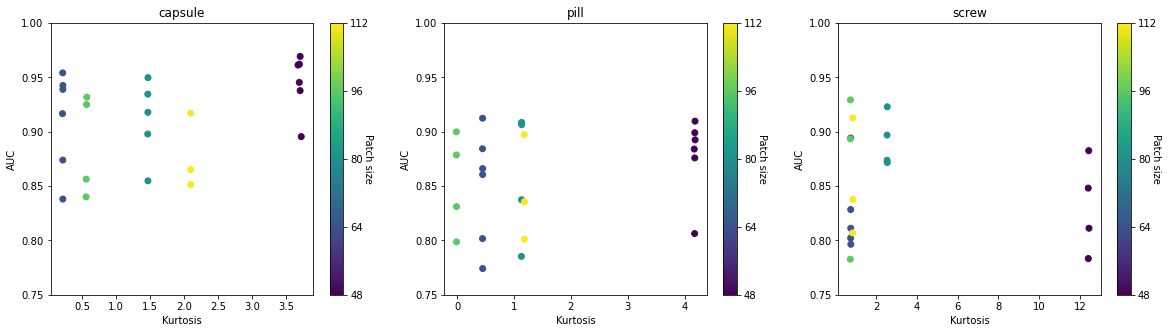

In [21]:
# As

plt.rcParams["figure.figsize"] = (20, 5)

Ps = [48, 64, 80, 96, 112]

from matplotlib.colors import ListedColormap

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]
cMap = ListedColormap(colors)

for i,clazz in enumerate([10, 3, 13]):
    plt.subplot(1,3,i+1)
    log_ = pd.concat(log)
    log_ = log_[log_["class"] == str(clazz)]
    #log_ = log_[log_["P"] != str(112)]
    
    x = log_["kurt"].astype(np.float32)
    d = log_["dim"].astype(np.float32)
    #x = x / d
    y = log_["auc_local"].astype(np.float32)
    c = log_["P"].astype(np.float32)
    sctr = plt.scatter(x, y, c=c)
    plt.title(f"{MVTEC.CLASSES[clazz]}")
    plt.xlabel("Kurtosis")
    plt.ylabel("AUC")
    plt.ylim(0.75, 1.0)
    #plt.xlim(x.min(), x.max())
    #plt.xticks(np.linspace(10, 180, 3))
    
    ax = plt.colorbar(sctr)
    ax.set_ticks(Ps)
    ax.set_label('Patch size', rotation=270)
    #plt.legend()
#tikzplotlib.save("pill_capsule_screw_P_vs_Var.tex")

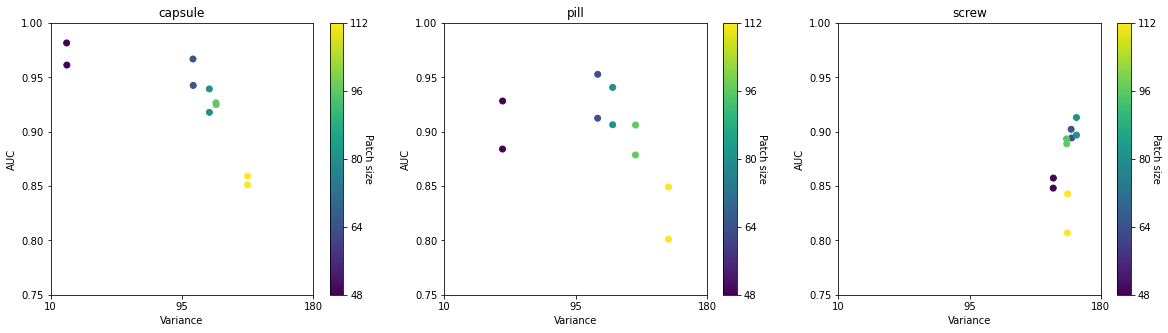

In [249]:
# As

plt.rcParams["figure.figsize"] = (20, 5)

Ps = [48, 64, 80, 96, 112]

from matplotlib.colors import ListedColormap

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]
cMap = ListedColormap(colors)

for i,clazz in enumerate([10, 3, 13]):
    plt.subplot(1,3,i+1)
    log_ = pd.concat(log)
    log_ = log_[log_["class"] == str(clazz)]
    #log_ = log_[log_["P"] != str(112)]
    
    x = log_["intra_var"].astype(np.float32)
    d = log_["dim"].astype(np.float32)
    x = x / d
    y = log_["auc_local"].astype(np.float32)
    c = log_["P"].astype(np.float32)
    sctr = plt.scatter(x, y, c=c)
    plt.title(f"{MVTEC.CLASSES[clazz]}")
    plt.xlabel("Variance")
    plt.ylabel("AUC")
    plt.ylim(0.75, 1.0)
    #plt.xlim(x.min(), x.max())
    plt.xticks(np.linspace(10, 180, 3))
    
    ax = plt.colorbar(sctr)
    ax.set_ticks(Ps)
    ax.set_label('Patch size', rotation=270)
    #plt.legend()
tikzplotlib.save("pill_capsule_screw_P_vs_Var.tex")

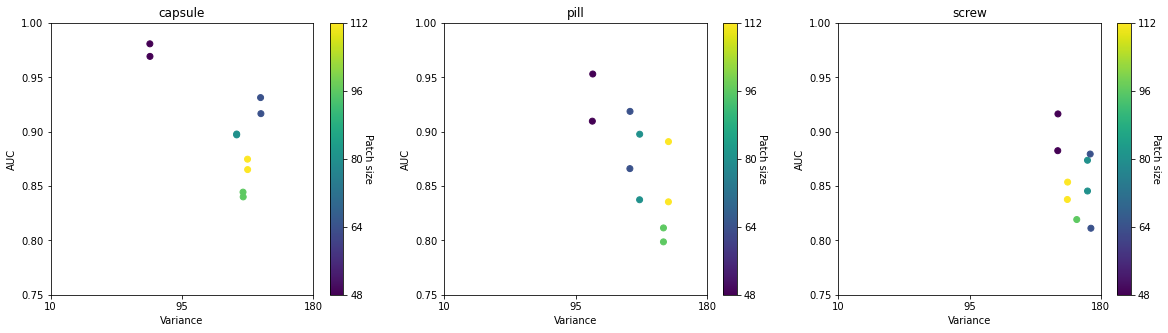

In [253]:
# As + 1

plt.rcParams["figure.figsize"] = (20, 5)

Ps = [48, 64, 80, 96, 112]

from matplotlib.colors import ListedColormap

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]
cMap = ListedColormap(colors)

for i,clazz in enumerate([10, 3, 13]):
    plt.subplot(1,3,i+1)
    log_ = pd.concat(log)
    log_ = log_[log_["class"] == str(clazz)]
    #log_ = log_[log_["P"] != str(112)]
    
    x = log_["intra_var"].astype(np.float32)
    d = log_["dim"].astype(np.float32)
    x = x / d
    y = log_["auc_local"].astype(np.float32)
    c = log_["P"].astype(np.float32)
    sctr = plt.scatter(x, y, c=c)
    plt.title(f"{MVTEC.CLASSES[clazz]}")
    plt.xlabel("Variance")
    plt.ylabel("AUC")
    plt.ylim(0.75, 1.0)
    #plt.xlim(x.min(), x.max())
    plt.xticks(np.linspace(10, 180, 3))
    
    ax = plt.colorbar(sctr)
    ax.set_ticks(Ps)
    ax.set_label('Patch size', rotation=270)
    #plt.legend()
tikzplotlib.save("pill_capsule_screw_P_vs_Var.tex")

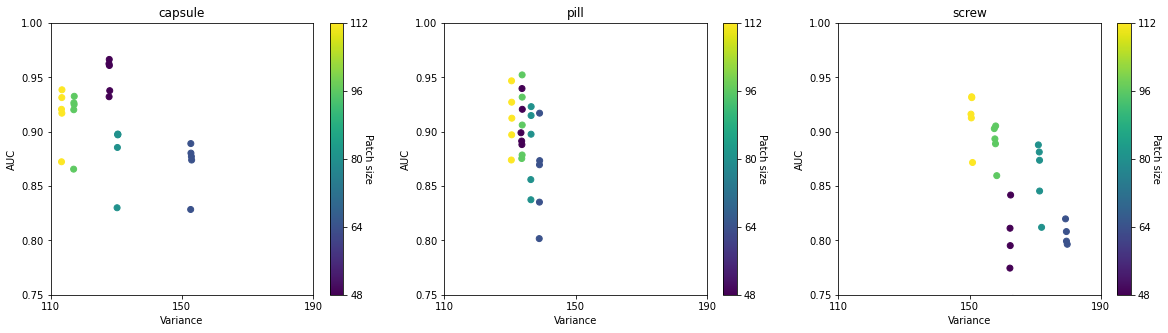

In [245]:
# Fixed A = 112

plt.rcParams["figure.figsize"] = (20, 5)

Ps = [48, 64, 80, 96, 112]

from matplotlib.colors import ListedColormap

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]
cMap = ListedColormap(colors)

for i,clazz in enumerate([10, 3, 13]):
    plt.subplot(1,3,i+1)
    log_ = pd.concat(log)
    log_ = log_[log_["class"] == str(clazz)]
    #log_ = log_[log_["P"] != str(112)]
    
    x = log_["intra_var"].astype(np.float32)
    d = log_["dim"].astype(np.float32)
    x = x / d
    y = log_["auc_local"].astype(np.float32)
    c = log_["P"].astype(np.float32)
    sctr = plt.scatter(x, y, c=c)
    plt.title(f"{MVTEC.CLASSES[clazz]}")
    plt.xlabel("Variance")
    plt.ylabel("AUC")
    plt.ylim(0.75, 1.0)
    #plt.xlim(x.min(), x.max())
    plt.xticks(np.linspace(110, 190, 3))
    
    ax = plt.colorbar(sctr)
    ax.set_ticks(Ps)
    ax.set_label('Patch size', rotation=270)
    #plt.legend()
tikzplotlib.save("pill_capsule_screw_P_vs_Var.tex")

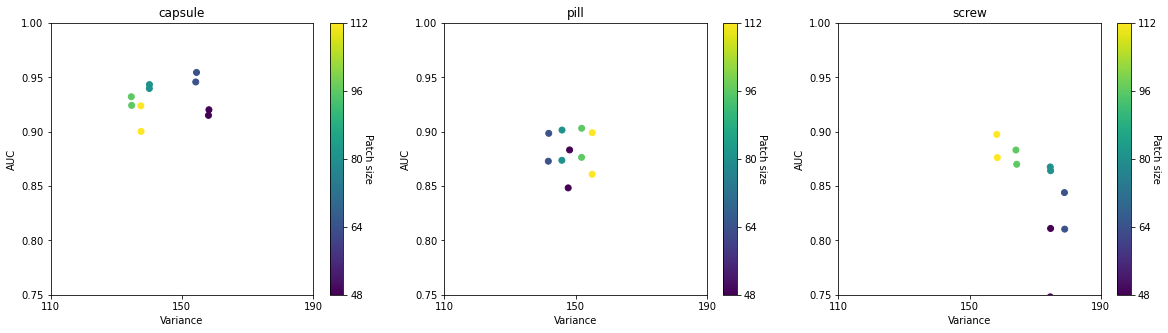

In [257]:
# Fixed A = 224

plt.rcParams["figure.figsize"] = (20, 5)

Ps = [48, 64, 80, 96, 112]

from matplotlib.colors import ListedColormap

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]
cMap = ListedColormap(colors)

for i,clazz in enumerate([10, 3, 13]):
    plt.subplot(1,3,i+1)
    log_ = pd.concat(log)
    log_ = log_[log_["class"] == str(clazz)]
    #log_ = log_[log_["P"] != str(112)]
    
    x = log_["intra_var"].astype(np.float32)
    d = log_["dim"].astype(np.float32)
    x = x / d
    y = log_["auc_local"].astype(np.float32)
    c = log_["P"].astype(np.float32)
    sctr = plt.scatter(x, y, c=c)
    plt.title(f"{MVTEC.CLASSES[clazz]}")
    plt.xlabel("Variance")
    plt.ylabel("AUC")
    plt.ylim(0.75, 1.0)
    #plt.xlim(x.min(), x.max())
    plt.xticks(np.linspace(110, 190, 3))
    
    ax = plt.colorbar(sctr)
    ax.set_ticks(Ps)
    ax.set_label('Patch size', rotation=270)
    #plt.legend()
tikzplotlib.save("pill_capsule_screw_P_vs_Var.tex")

# Visualize Feature Space

In [5]:
import seaborn as sns
import tikzplotlib

In [126]:
log = []

As = [64, 80, 96, 112, 128, 144]
P_fixed = 64
s = 16
blocks = [5,6]
p = 1
n = 100000
run = -1

for run in range(1):
    for clazz in [3, 10, 13, 0]:

        for i,P in enumerate([48, 64, 80]):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks, reshape=(P_fixed, P_fixed))
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks, reshape=(P_fixed, P_fixed))
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks, reshape=(P_fixed, P_fixed))

            A = 96
            r = int( (A - P_fixed)/s + 1 )

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            intra_var = intra_class_variance(X, T, mu, means, cov, BSZ=(p, p), rho=r)
            inter_var = inter_class_variance(means)
            dif_var   = intra_var - inter_var

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], len(X_), len(X)*X.shape[2]*X.shape[3], cov.shape[0], r, intra_var, inter_var, dif_var, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "n_patches", "dim", "rho", "intra_var", "inter_var", "dif_var", "auc", "auc_local"])) 
            
            display(log[-1])
            
            break

        break
            
        
            


run class class_name   A   P   s BSZ layers n_samples n_patches   dim rho  \
0   0     3       pill  96  48  16   1      5       267     38448  4352   3   

   intra_var  inter_var    dif_var                 auc           auc_local  
0  539979.75  123356.02  416623.72  0.9050736497545008  0.9206219312602291

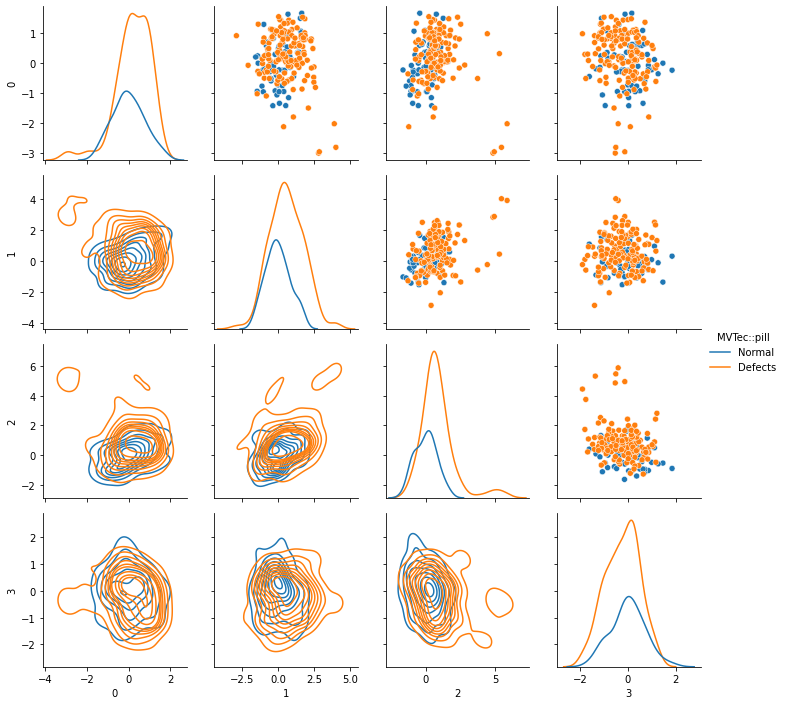

In [127]:
np.random.seed(1)
c = 4

data_in = fmap_to_tiles( local_hotelling(X[np.random.permutation(len(X))][:len(data_out)], T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0, reduce="fmap") ).mean(1)
data_out = fmap_to_tiles( local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0, reduce="fmap") ).mean(1)

cols = np.argsort( np.abs(data_out.mean(0) - data_in.mean(0))/data_in.mean(0) )[::-1][:c]
# cols1 = np.argsort( np.abs(data_out.std(0) - data_in.std(0)))[::-1][:c//2]
# cols2 = np.random.permutation(data_out.shape[1])[:c//2]
# cols = np.concatenate([cols1, cols2])

data_in = data_in[:, cols]
data_out = data_out[:, cols]

data = pd.DataFrame.from_records(np.concatenate([data_in, data_out]))
data[ "MVTec::" + MVTEC.CLASSES[clazz]] = ["Normal"] * len(data_in) + ["Defects"] * len(data_out)

g = sns.PairGrid(data, diag_sharey=False, hue="MVTec::" + MVTEC.CLASSES[clazz])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()

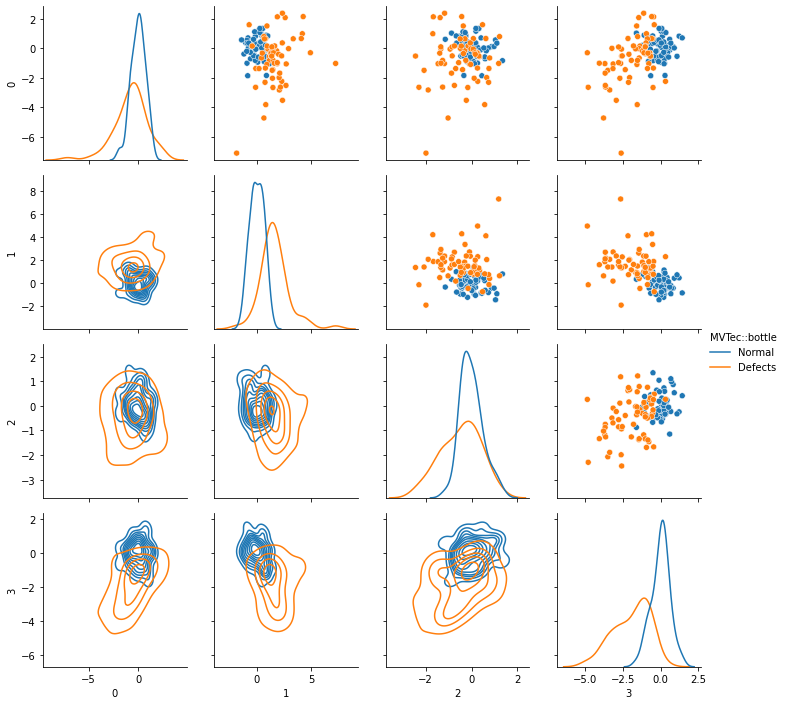

In [125]:
np.random.seed(1)
c = 4

data_in = fmap_to_tiles( local_hotelling(X[np.random.permutation(len(X))][:len(data_out)], T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0, reduce="fmap") ).mean(1)
data_out = fmap_to_tiles( local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0, reduce="fmap") ).mean(1)

cols = np.argsort( np.abs(data_out.mean(0) - data_in.mean(0))/data_in.mean(0) )[::-1][:c]
# cols1 = np.argsort( np.abs(data_out.std(0) - data_in.std(0)))[::-1][:c//2]
# cols2 = np.random.permutation(data_out.shape[1])[:c//2]
# cols = np.concatenate([cols1, cols2])

data_in = data_in[:, cols]
data_out = data_out[:, cols]

data = pd.DataFrame.from_records(np.concatenate([data_in, data_out]))
data[ "MVTec::" + MVTEC.CLASSES[clazz]] = ["Normal"] * len(data_in) + ["Defects"] * len(data_out)

g = sns.PairGrid(data, diag_sharey=False, hue="MVTec::" + MVTEC.CLASSES[clazz])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()

tikzplotlib.save("tex/bottle_scatter_plot.tex")

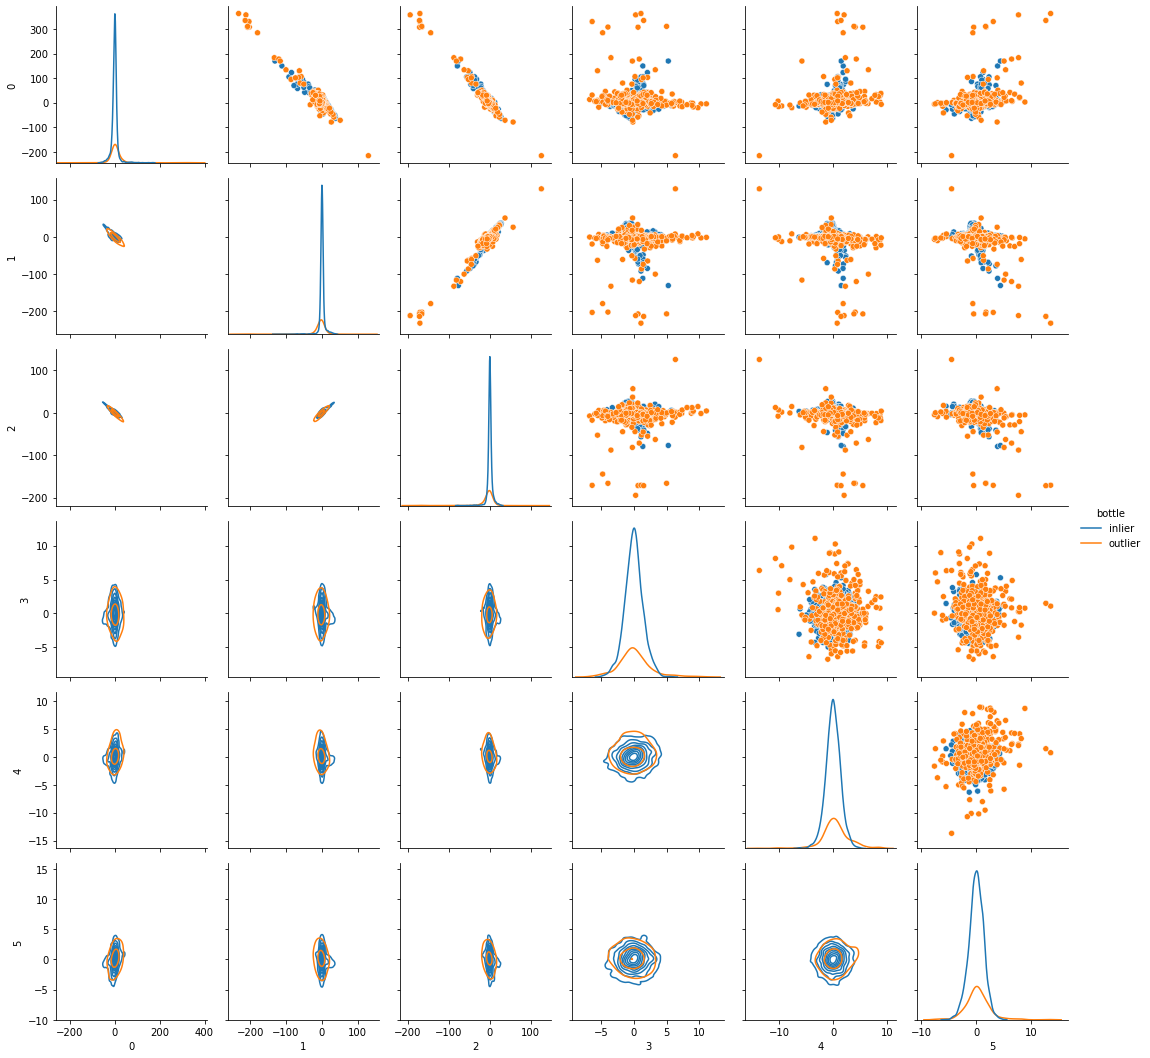

In [114]:
np.random.seed(10)
c = 6

data_in = fmap_to_tiles( local_hotelling(X[np.random.permutation(len(X))][:len(data_out)], T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0, reduce="fmap") )
data_in = data_in.reshape(len(data_in) * data_in.shape[1], -1)
data_out = fmap_to_tiles( local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r, avg_stride=r, avg_padd=0, reduce="fmap") )
data_out = data_out.reshape(len(data_out) * data_out.shape[1], -1)

cols1 = np.argsort(np.abs(data_out.mean(0) - data_in.mean(0)) )[::-1][:c//2]
cols2 = np.random.permutation(data_out.shape[1])[:c//2]
cols = np.concatenate([cols1, cols2])

data_in = data_in[:, cols]
data_out = data_out[:, cols]

data = pd.DataFrame.from_records(np.concatenate([data_in, data_out]))
data[MVTEC.CLASSES[clazz]] = ["inlier"] * len(data_in) + ["outlier"] * len(data_out)

g = sns.PairGrid(data, diag_sharey=False, hue=MVTEC.CLASSES[clazz])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()